=== 讀取資料 ===
原始資料形狀: (171308, 15)
目標變數分布:
treatment
1    93032
0    78276
Name: count, dtype: int64

=== 步驟1: 資料分組 ===
分組特徵 'Gender' 的原始分布:
Gender
0    135720
1     35588
Name: count, dtype: int64
唯一值: [1 0]

分析組別: Gender=1
篩選後資料筆數: 35588
篩選後目標變數分布:
treatment
1    25172
0    10416
Name: count, dtype: int64

=== 步驟2: 特徵編碼 ===
使用的特徵: ['Gender', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Coping_Struggles']
編碼前特徵數量: 6
編碼後特徵數量: 6
編碼後特徵名稱: ['Gender', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Coping_Struggles']

注意：分組特徵 'Gender' 相關的編碼特徵: ['Gender']
  Gender: 1 個唯一值
    警告：Gender 在此組別中只有一個值，可能沒有預測價值

=== 步驟3: 資料切分 ===
訓練集大小: (28470, 6)
測試集大小: (7118, 6)
使用特徵數量: 6

=== 步驟4: 模型訓練 ===

=== 模型評估結果 ===
分析組別: Gender=1
使用特徵: ['Gender', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Coping_Struggles']
NPV 分數: 0.7678
準確率: 0.8049
精確率: 0.8125
召回率: 0.9442
F1分數: 0.8734

=== SHAP 分析 ===
SHAP values type: 

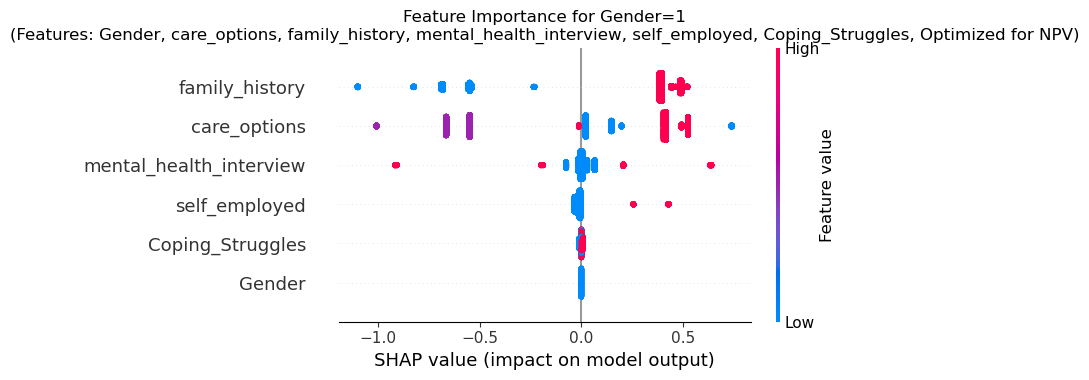


平均 SHAP 值（針對 Gender=1 分類為 1 的特徵重要性）:
family_history             0.003170
mental_health_interview    0.003025
Coping_Struggles           0.000087
Gender                     0.000000
care_options              -0.000929
self_employed             -0.005467
dtype: float64

=== 其他 SHAP 視覺化 (Gender=1) ===


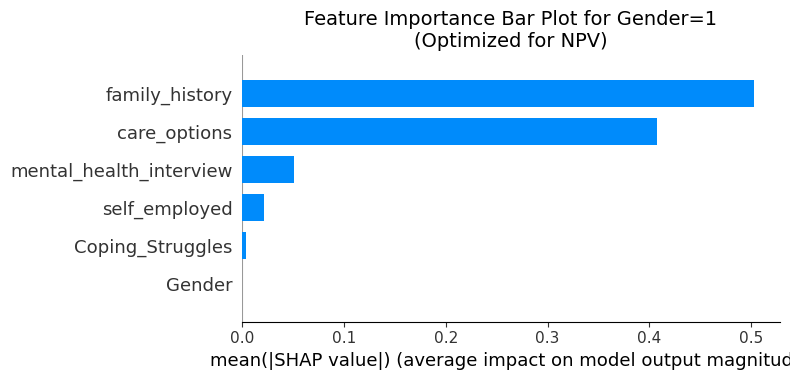

Waterfall plot 出現錯誤: waterfall() got multiple values for argument 'show'
跳過 Waterfall plot...

=== 分析總結 ===
1. 分析組別: Gender=1
2. 組別資料量: 35588 筆
3. 使用的特徵: ['Gender', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Coping_Struggles']
4. 編碼後特徵數量: 6
5. 模型優化目標: NPV
6. 最終 NPV 分數: 0.7678

模型特徵重要性（LightGBM內建）:
                   Feature  Importance
5         Coping_Struggles         701
1             care_options         400
3  mental_health_interview         400
4            self_employed         200
2           family_history         100
0                   Gender           0

=== 與全體資料的比較 ===
全體資料中 treatment 的分布:
treatment
1    0.543069
0    0.456931
Name: proportion, dtype: float64

Gender=1 中 treatment 的分布:
treatment
1    0.707317
0    0.292683
Name: proportion, dtype: float64


<Figure size 1200x800 with 0 Axes>

In [1]:
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings

# 過濾 SHAP 的警告訊息
warnings.filterwarnings('ignore', message='LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')

# --- 自定義評估指標 ---
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn) if (tn + fn) > 0 else 0

# --- 使用者輸入設定 ---
optimize_for = 'npv'  # 'specificity' 或 'npv'
csv_path = r"C:\User\Mental Health Dataset (US).csv"
feature_columns = []
target_column = 'treatment'

# --- 分組分析設定 ---
group_by_feature = None  # 要分組的特徵名稱
target_group_value = None       # 要分析的特定組別值

# --- 讀取資料 ---
print("=== 讀取資料 ===")
data = pd.read_csv(csv_path)
print(f"原始資料形狀: {data.shape}")
print(f"目標變數分布:\n{data[target_column].value_counts()}")

# --- 步驟1: 資料分組 ---
print(f"\n=== 步驟1: 資料分組 ===")

# 檢查分組特徵的原始值
print(f"分組特徵 '{group_by_feature}' 的原始分布:")
if group_by_feature in data.columns:
    print(data[group_by_feature].value_counts())
    unique_values = data[group_by_feature].unique()
    print(f"唯一值: {unique_values}")
else:
    print(f"錯誤：找不到特徵 '{group_by_feature}'")
    print(f"可用特徵: {list(data.columns)}")
    exit()

# 根據原始值進行分組篩選
if target_group_value in data[group_by_feature].values:
    mask = data[group_by_feature] == target_group_value
    group_description = f"{group_by_feature}={target_group_value}"
else:
    print(f"錯誤：值 '{target_group_value}' 不存在於特徵 '{group_by_feature}' 中")
    print(f"可用值: {data[group_by_feature].unique()}")
    exit()

# 篩選資料
filtered_data = data[mask].copy()
print(f"\n分析組別: {group_description}")
print(f"篩選後資料筆數: {len(filtered_data)}")
print(f"篩選後目標變數分布:")
print(filtered_data[target_column].value_counts())

# 檢查資料是否足夠進行分析
if len(filtered_data) < 20:
    print("警告：該組別資料筆數過少，可能影響模型效果")
if filtered_data[target_column].nunique() < 2:
    print("警告：該組別中目標變數只有一個類別，無法進行二分類分析")
    exit()

# --- 步驟2: 對分組後的資料進行特徵編碼 ---
print(f"\n=== 步驟2: 特徵編碼 ===")

# 使用您指定的特徵
print(f"使用的特徵: {feature_columns}")

# 檢查所有指定特徵是否存在
missing_features = [col for col in feature_columns if col not in filtered_data.columns]
if missing_features:
    print(f"錯誤：以下特徵在資料中不存在: {missing_features}")
    print(f"資料中可用的特徵: {list(filtered_data.columns)}")
    exit()

# 對分組後的資料進行編碼
X_encoded = pd.get_dummies(filtered_data[feature_columns], drop_first=True)
y_filtered = filtered_data[target_column]

print(f"編碼前特徵數量: {len(feature_columns)}")
print(f"編碼後特徵數量: {X_encoded.shape[1]}")
print(f"編碼後特徵名稱: {list(X_encoded.columns)}")

# 檢查分組特徵在編碼後的狀況
group_related_features = [col for col in X_encoded.columns if col.startswith(group_by_feature)]
if group_related_features:
    print(f"\n注意：分組特徵 '{group_by_feature}' 相關的編碼特徵: {group_related_features}")
    # 檢查這些特徵是否有變異
    for col in group_related_features:
        unique_vals = X_encoded[col].nunique()
        print(f"  {col}: {unique_vals} 個唯一值")
        if unique_vals == 1:
            print(f"    警告：{col} 在此組別中只有一個值，可能沒有預測價值")

# --- 資料切分 ---
print(f"\n=== 步驟3: 資料切分 ===")
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_filtered, test_size=0.2, random_state=42)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"使用特徵數量: {X_encoded.shape[1]}")

# --- 手動設定模型參數 ---
params = {
    'class_weight': None,
    'lambda_l1': None,
    'lambda_l2': None,
    'learning_rate': None,
    'max_depth': None,
    'min_child_samples': None,  
    'min_data_in_leaf': None,   
    'n_estimators': None,
    'num_leaves': None,
    'random_state': None
}

# --- 模型訓練 ---
print(f"\n=== 步驟4: 模型訓練 ===")
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

# --- 預測與評估 ---
y_pred = model.predict(X_test)
if optimize_for == 'specificity':
    score = specificity_score(y_test, y_pred)
elif optimize_for == 'npv':
    score = npv_score(y_test, y_pred)
else:
    raise ValueError("optimize_for 必須是 'specificity' 或 'npv'")

print(f"\n=== 模型評估結果 ===")
print(f"分析組別: {group_description}")
print(f"使用特徵: {feature_columns}")
print(f"{optimize_for.upper()} 分數: {score:.4f}")

# 額外評估指標
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"準確率: {accuracy_score(y_test, y_pred):.4f}")
print(f"精確率: {precision_score(y_test, y_pred):.4f}")
print(f"召回率: {recall_score(y_test, y_pred):.4f}")
print(f"F1分數: {f1_score(y_test, y_pred):.4f}")

# --- SHAP 解釋 ---
print(f"\n=== SHAP 分析 ===")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# --- 處理 SHAP 值格式 ---
print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values is a list with {len(shap_values)} elements")
    if len(shap_values) == 2:
        shap_values_to_plot = shap_values[1]  # 正類別的 SHAP 值
    else:
        shap_values_to_plot = shap_values[0]
else:
    shap_values_to_plot = shap_values

print(f"Shape of SHAP values to plot: {shap_values_to_plot.shape}")

# --- SHAP summary plot ---
plt.figure(figsize=(12, 8))
try:
    shap.summary_plot(shap_values_to_plot, X_test, show=False)
    plt.title(f"Feature Importance for {group_description}\n(Features: {', '.join(feature_columns)}, Optimized for {optimize_for.upper()})", fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Summary plot 出現錯誤: {e}")
    # 備選方案：使用 bar plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
    plt.title(f"Feature Importance for {group_description}\n(Features: {', '.join(feature_columns)}, Optimized for {optimize_for.upper()})", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- 印出平均 SHAP 值 ---
mean_shap_df = pd.DataFrame(shap_values_to_plot, columns=X_test.columns).mean().sort_values(ascending=False)
print(f"\n平均 SHAP 值（針對 {group_description} 分類為 1 的特徵重要性）:")
print(mean_shap_df)

# --- 其他 SHAP 視覺化 ---
print(f"\n=== 其他 SHAP 視覺化 ({group_description}) ===")

# 1. Bar plot (特徵重要性排序)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
plt.title(f"Feature Importance Bar Plot for {group_description}\n(Optimized for {optimize_for.upper()})", fontsize=14)
plt.tight_layout()
plt.show()

# 2. Waterfall plot (單個預測的解釋)
if len(X_test) > 0:
    plt.figure(figsize=(12, 8))
    # 處理 expected_value 的格式
    if isinstance(explainer.expected_value, (list, tuple)):
        expected_val = explainer.expected_value[1]  # 正類別的期望值
    else:
        expected_val = explainer.expected_value
    
    try:
        shap.waterfall_plot(expected_val, shap_values_to_plot[0], X_test.iloc[0], show=False)
        plt.title(f"Waterfall Plot for {group_description} - First Test Sample\n(Optimized for {optimize_for.upper()})", fontsize=12)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Waterfall plot 出現錯誤: {e}")
        print("跳過 Waterfall plot...")

# 3. Force plot (如果樣本數不太多)
if len(X_test) <= 10:
    print(f"Force plot for {group_description} (互動式，在 Jupyter 中顯示):")
    try:
        # 處理 expected_value 的格式
        if isinstance(explainer.expected_value, (list, tuple)):
            expected_val = explainer.expected_value[1]
        else:
            expected_val = explainer.expected_value
        
        shap.force_plot(expected_val, shap_values_to_plot, X_test)
    except Exception as e:
        print(f"Force plot 出現錯誤: {e}")
        print("跳過 Force plot...")

# --- 分析總結 ---
print(f"\n=== 分析總結 ===")
print(f"1. 分析組別: {group_description}")
print(f"2. 組別資料量: {len(filtered_data)} 筆")
print(f"3. 使用的特徵: {feature_columns}")
print(f"4. 編碼後特徵數量: {X_encoded.shape[1]}")
print(f"5. 模型優化目標: {optimize_for.upper()}")
print(f"6. 最終 {optimize_for.upper()} 分數: {score:.4f}")

# 顯示編碼後各特徵的重要性（基於模型的 feature_importances_）
if hasattr(model, 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n模型特徵重要性（LightGBM內建）:")
    print(feature_importance_df)

# --- 與全體資料的比較 ---
print(f"\n=== 與全體資料的比較 ===")
print(f"全體資料中 {target_column} 的分布:")
print(data[target_column].value_counts(normalize=True))
print(f"\n{group_description} 中 {target_column} 的分布:")
print(filtered_data[target_column].value_counts(normalize=True))